# Load metrics file in CSV
TODO: load from github when the repo become public

In [161]:
#from google.colab import files
#import io
import pandas as pd

#uploaded = files.upload()

#metrics = pd.read_csv(io.BytesIO(uploaded['metrics.csv']))

metrics_spacy_ner = pd.read_csv("/content/metrics_spacy_ner.csv")
metrics_camembert = pd.read_csv("/content/metrics_camembert.csv")
metrics_camembert_pretrained = pd.read_csv("/content/metrics_camembert_pretrained.csv")

metrics = pd.concat([metrics_spacy_ner,metrics_camembert,metrics_camembert_pretrained],  keys=['SpaCy NER', "CamemBERT",'CamemBERT.pretrained'])
metrics

run dataset  ...  eval_steps_per_second  epoch
SpaCy NER            0     1    test  ...                    NaN    NaN
                     1     1    test  ...                    NaN    NaN
                     2     1    test  ...                    NaN    NaN
                     3     1    test  ...                    NaN    NaN
                     4     1    test  ...                    NaN    NaN
...                      ...     ...  ...                    ...    ...
CamemBERT.pretrained 35    5    test  ...                 11.084  32.00
                     36    5    test  ...                  9.786  20.00
                     37    5    test  ...                 10.953   8.00
                     38    5    test  ...                 10.230   6.00
                     39    5    test  ...                 11.140   2.01

[96 rows x 13 columns]

# Build the averaged table


In [162]:
# Store p/r/f1 as percentages
eval_ = ["eval_f1","eval_precision","eval_recall"]
metrics[eval_] = metrics[eval_].multiply(100., axis=1)


In [163]:
# Average over runs
averaged = metrics.groupby(level=0).apply(lambda grp: grp.groupby(by="trainsize").mean())
averaged.set_index(["trainsize_percent"], append=True,inplace=True)

# Keep just the necessary columns
averaged=averaged[["eval_precision","eval_recall","eval_f1"]]

# Set pretty names
averaged.index.names = ['Model','Trainset Size',"%"]
averaged.rename(columns={"eval_precision": "Precision", "eval_recall": "Recall", "eval_f1":"F1 score"}, errors="raise", inplace=True)

# Create the results table
Title: "Experimental results of the NER models performances when trained on varying numbers of examples"

In [164]:
# Filter and transpose to obtain the latex table
latex_table = averaged.stack().unstack(level=[1,2])

# Swap model name and metrics to get a nice table
latex_table = latex_table.swaplevel(0,1).sort_index(level=0)

caption = "Experimental results of the NER models performances when trained on varying numbers of examples"
print(latex_table.to_latex(float_format="%.1f", multirow=True, caption=caption))
latex_table

\begin{table}
\centering
\caption{Experimental results of the NER models performances when trained on varying numbers of examples}
\begin{tabular}{llrrrrrrrr}
\toprule
       & Trainset Size &  49   &  99   &  199  &  398  &  796  &  1593 &  3186 &  6373 \\
       & \% & 0.8   & 1.5   & 3.1   & 6.2   & 12.5  & 25.0  & 50.0  & 100.0 \\
{} & Model &       &       &       &       &       &       &       &       \\
\midrule
\multirow{3}{*}{F1 score} & CamemBERT &  89.6 &  90.1 &  92.8 &  93.4 &  94.3 &  95.3 &  94.7 &  95.5 \\
       & CamemBERT.pretrained &  90.0 &  91.4 &  92.9 &  93.4 &  94.2 &  94.5 &  94.8 &  95.4 \\
       & SpaCy NER &  87.0 &  89.0 &  90.3 &  91.9 &  92.1 &  92.8 &  93.2 &  93.5 \\
\cline{1-10}
\multirow{3}{*}{Precision} & CamemBERT &  87.8 &  87.8 &  91.7 &  93.0 &  93.4 &  95.4 &  93.8 &  95.8 \\
       & CamemBERT.pretrained &  87.9 &  89.8 &  91.6 &  92.7 &  93.4 &  94.0 &  94.1 &  95.4 \\
       & SpaCy NER &  85.6 &  87.7 &  90.0 &  92.0 &  92.4 &  92.8 &  93

Trainset Size                        49         99    ...       3186       6373
%                                   0.8        1.5    ...      50.0       100.0
          Model                                       ...                      
F1 score  CamemBERT             89.627972  90.087605  ...  94.680931  95.451099
          CamemBERT.pretrained  90.025306  91.399778  ...  94.785345  95.361196
          SpaCy NER             87.043738  88.992014  ...  93.216490  93.519860
Precision CamemBERT             87.839007  87.831896  ...  93.789833  95.814307
          CamemBERT.pretrained  87.914924  89.819356  ...  94.120203  95.360205
          SpaCy NER             85.555070  87.651826  ...  93.089527  93.679900
Recall    CamemBERT             91.495468  92.462236  ...  95.589124  95.090634
          CamemBERT.pretrained  92.241692  93.039275  ...  95.462236  95.362538
          SpaCy NER             88.586103  90.377644  ...  93.344411  93.362538

[9 rows x 8 columns]

# Create the graphs

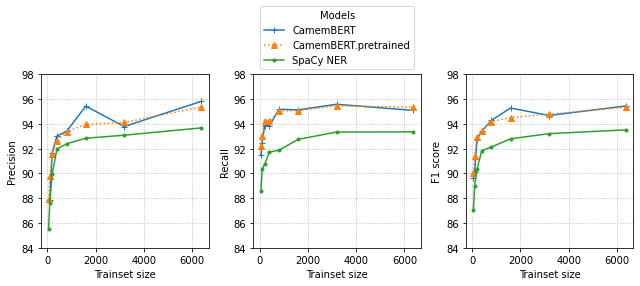

In [365]:
averaged = metrics.groupby(level=0).apply(lambda grp: grp.groupby(by="trainsize").mean())

# Keep just the necessary columns
averaged=averaged[["eval_precision","eval_recall","eval_f1"]]
prec = averaged["eval_precision"].unstack().T
recall = averaged["eval_recall"].unstack().T
f1 = averaged["eval_f1"].unstack().T

import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, sharex='row', figsize=(9, 3))
fig.tight_layout()

# plot subplots
ls=['+-','^:','.-']
ax1 = prec.plot(ax=axes[0], xlabel="Trainset size", ylabel="Precision", legend=False, style=ls)
ax2 = recall.plot(ax=axes[1], xlabel="Trainset size",ylabel="Recall", legend=False, style=ls)
ax3 = f1.plot(ax=axes[2], xlabel="Trainset size",ylabel="F1 score", legend=False, style=ls)

# Align y ticks
ax1.set_yticks(ax1.get_yticks())
ax2.set_yticks(ax1.get_yticks())
ax3.set_yticks(ax1.get_yticks())

                           
# Set shared legend above the plots
ax2.legend(loc="lower center",   # Position of legend
           title="Models",  # Title for the legend
           bbox_to_anchor=(0.5, 1)
           )

ax1.grid(linestyle='dotted')
ax2.grid(linestyle='dotted')
ax3.grid(linestyle='dotted')

plt.savefig('experiment_1.png', dpi=300, format='png')
#averaged.droplevel(2)
#averaged.droplevel(0).plot(subplots=True)
#unstack(level=0).plot(subplots=True)